# JAX 作为加速版的 NumPy

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/01-jax-basics.ipynb)

*Authors: Rosalia Schneider & Vladimir Mikulik*

本小节，你将学习到JAX的基础。

## JAX numpy

首先，你可以先把JAX理解为*支持自动微分的NumPy，并且可以运行在GPU和TPU上面*。


In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


是不是和NumPy一样，JAX最吸引人的地方就是你不需要重新学习一套API，只需要将`np`替换为`jnp`，大多数NumPy程序就可以无缝切换到JAX，当然，二者还是有区别的，第一个区别就是数组类型（dtype），JAX数组类型是 `DeviceArray`。

In [2]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

JAX的一大优势是同一个代码，即可以运行在CPU，也可以运行在GPU或TPU。

来看一个点积的例子，使用 `%timeit` 来记录运行时间。

当JAX代码执行时，相应的算子/计算操作会尽量被分发到加速卡上面异步执行，执行结果也没必要立即返回到host，此时`%timeit`记录到仅仅是程序分发的时长，所以我们使用`block_until_ready()`来记录程序真正的执行时长可以参考 [Asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#asynchronous-dispatch)。

In [3]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

1.37 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## JAX : `grad`

JAX的一大特点就是可以对Python函数进行多种转换（transformation）。我们来看第一个要学习的转换 `jax.grad`，它能对一个输出是标量的函数，计算其导函数。

我们来看一个例子。

In [4]:
def sum_of_squares(x):
  return jnp.sum(x**2)

使用 `jax.grad` 来得到 `sum_of_squares` 的导函数（一个新的函数）。注意新的导函数只能计算第一个传参的梯度。

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [6]:
def sum_of_squares_multi(x, y):
  return jnp.sum(x**2 + y**2)

In [8]:
sum_of_squares_multi_dx_dy = jax.grad(sum_of_squares_multi)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])
y = jnp.asarray([2.0, 3.0, 4.0, 6.0])

print(sum_of_squares_multi(x, y))

print(sum_of_squares_multi_dx_dy(x, y))  # 只计算了第一个传承x的梯度

95.0
[2. 4. 6. 8.]


你可以把 `jax.grad` 理解为微分中的梯度符号， $\nabla$ 。 给定函数 $f(x)$, $\nabla f$ 表示导函数

$$
(\nabla f)(x)_i = \frac{\partial f}{\partial x_i}(x).
$$

所以，`jax.grad(f)` 就是导函数，从而 `jax.grad(f)(x)` 就是对 `x`求梯度。

（和 $\nabla$一眼， `jax.grad` 只作用于返回标量的函数。）


这使得JAX API和其他的自动微分框架，比如TF和PyTorch大不相同，后两者是根据loss tensor来计算梯度，也就是调用 `loss.backward()` 。而JAX直接作用于**函数**，和数学课上学的那样。一旦你理解了，这么做就很自然了，你写的损失函数本质上就是一个关于参数和数据的函数，在数学课堂上，我们就是通过计算导函数来计算参数梯度的。

默认情况下， `jax.grad` 只对第一个函数传参求导：

In [9]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


如果我们要计算对其他传参的梯度，甚至是多个变量，可以使用 `argnums`:

In [10]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # 对x和y都计算梯度

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

`jax.grad`很好用，可是神经网络通常包含了Million级别的参数，难道我们要一一列出来，写一个巨长的传参列表，计算梯度？当然不是了，JAX提供饿了一种数据结构叫做 'pytrees'，可以将参数打包，一把计算梯度，更多信息可以看 [later guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb)。但是大致是这样的：

```
def loss_fn(params, data):
  ...

grads = jax.grad(loss_fn)(params, data_batch)
```

其中 `params` 可以是一个数组构成的dict，而返回的 `grads` 是也是数组构成的dict。

## Value and Grad

有的时候，对于一个函数，我们既想得到函数值也想得到导函数值（对变量的梯度），比如我们会记录下训练集的loss，JAX提供了一个转换，很好用

In [11]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

返回的是一个tuple，(value, grad)。

```
jax.value_and_grad(f)(*xs) == (f(*xs), jax.grad(f)(*xs)) 
```

## Auxiliary data

除了记录最终的函数值，我们也可能想记录某些中间结果，是否可以让函数返回？

In [12]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.03999995, dtype=float32), DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

显然不行，前面我们提过 `jax.grad` 只能作用于返回标量的函数，现在返回的是tuple，可以用`has_aux`参数:

In [14]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

`has_aux` 表明函数返回 `(out, aux)`，`aux`是原始函数的第二个返回结果，而`out`是梯度值，它让 `jax.grad` 忽略 `aux`，专心计算梯度。

有点`value_and_grad`的味道。

## 和NumPy的差异

`jax.numpy` API 虽然和NumPy很像，但还是有区别的，最重要的区别是，JAX是函数式的编程范畴。

本文不会介绍什么是函数式编程，如果你对此不了解也没关系，只需要记住一点：不要写有副作用（side-effect）的函数就行了。

函数副作用指的是任何没有体现在函数返回值上面的影响，比如修改了全局变量：

In [17]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

In [18]:
in_place_modify(jnp.array(x))  # Raises error when we cast input to jnp.ndarray

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [13]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

现在反悔了一个新数组，原数组没有改动，所以函数没有副作用:

In [19]:
y

DeviceArray([1.1, 2.1, 3.1, 4.1], dtype=float32)

没有副作用的函数也被称为纯函数。如果你要用JAX转换，就要写纯函数。有的时候写不出来？可以寻求JAX中丰富的原语来帮助。

Isn't the pure version less efficient? Strictly, yes; we are creating a new array. However, as we will explain in the next guide, JAX computations are often compiled before being run using another program transformation, `jax.jit`. If we don't use the old array after modifying it 'in place' using indexed update operators, the compiler can recognise that it can in fact compile to an in-place modify, resulting in efficient code in the end.

Of course, it's possible to mix side-effectful Python code and functionally pure JAX code, and we will touch on this more later. As you get more familiar with JAX, you will learn how and when this can work. As a rule of thumb, however, any functions intended to be transformed by JAX should avoid side-effects, and the JAX primitives themselves will try to help you do that.

We will explain other places where the JAX idiosyncracies become relevant as they come up. There is even a section that focuses entirely on getting used to the functional programming style of handling state: [Part 7: Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb). However, if you're impatient, you can find a [summary of JAX's sharp edges](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) in the JAX docs.

## Your first JAX training loop

看一个线性回归的例子。

Our data is sampled according to $y = w_{true} x + b_{true} + \epsilon$.

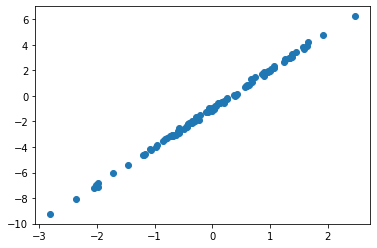

In [20]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

Therefore, our model is $\hat y(x; \theta) = wx + b$.

We will use a single array, `theta = [w, b]` to house both parameters:

In [21]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

The loss function is $J(x, y; \theta) = (\hat y - y)^2$.

In [22]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

How do we optimize a loss function? Using gradient descent. At each update step, we will find the gradient of the loss w.r.t. the parameters, and take a small step in the direction of steepest descent:

$\theta_{new} = \theta - 0.1 (\nabla_\theta J) (x, y; \theta)$

In [23]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In JAX, it's common to define an `update()` function that is called every step, taking the current parameters as input and returning the new parameters. This is a natural consequence of JAX's functional nature, and is explained in more detail in [The Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb).

This function can then be JIT-compiled in its entirety for maximum efficiency. The next guide will explain exactly how `jax.jit` works, but if you want to, you can try adding `@jax.jit` before the `update()` definition, and see how the training loop below runs much faster.

w: 3.00, b: -1.00


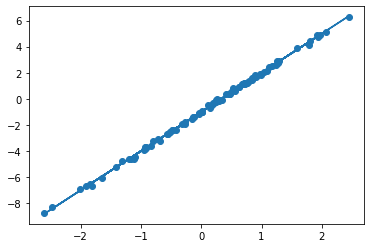

In [19]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

As you will see going through these guides, this basic recipe underlies almost all training loops you'll see implemented in JAX. The main difference between this example and real training loops is the simplicity of our model: that allows us to use a single array to house all our parameters. We cover managing more parameters in the later [pytree guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb). Feel free to skip forward to that guide now to see how to manually define and train a simple MLP in JAX.